# GPT-2 QLoRA + SEAL (Colab)

This notebook sets up the environment on Google Colab, installs dependencies, clones the repository, and walks through:
- Training GPT-2 Small with QLoRA (LoRA on 4-bit)
- Evaluating perplexity
- Running SEAL-style adaptation

Use Runtime → Change runtime type → GPU.

In [13]:
# Check GPU availability and basic environment
import torch
print('Torch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))
!nvidia-smi || true

Torch: 2.8.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
Thu Oct  9 22:43:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   32C    P0             51W /  400W |       5MiB /  81920MiB |      0%      Default |
|                                         |                        |     

In [14]:
%%capture
# Install libraries (keep Colab's PyTorch)
!pip -q install -U "transformers>=4.40" "datasets>=2.15" "peft>=0.8.0" "accelerate>=0.27.0" "bitsandbytes>=0.44.0"

In [15]:
# Clone this repository and change directory
import os
if not os.path.exists('/content/Ai-Research'):
    !git clone https://github.com/Hussain0327/Ai-Research.git /content/Ai-Research
%cd /content/Ai-Research
!ls -la

/content/Ai-Research
total 256
drwxr-xr-x 12 root root   4096 Oct  9 22:36 .
drwxr-xr-x  1 root root   4096 Oct  9 22:36 ..
-rw-r--r--  1 root root   6263 Oct  9 22:36 AI_Research.ipynb
-rw-r--r--  1 root root   2136 Oct  9 22:36 ARCHITECTURE.md
drwxr-xr-x  2 root root   4096 Oct  9 22:36 configs
-rw-r--r--  1 root root   1245 Oct  9 22:36 CONTRIBUTING.md
drwxr-xr-x  3 root root   4096 Oct  9 22:36 data
drwxr-xr-x  8 root root   4096 Oct  9 22:36 .git
drwxr-xr-x  3 root root   4096 Oct  9 22:36 .github
-rw-r--r--  1 root root    520 Oct  9 22:36 .gitignore
drwxr-xr-x  2 root root   4096 Oct  9 22:36 .ipynb_checkpoints
-rw-r--r--  1 root root   1067 Oct  9 22:36 LICENSE
-rw-r--r--  1 root root  11021 Oct  9 22:36 Makefile
-rw-r--r--  1 root root   1718 Oct  9 22:36 pyproject.toml
-rw-r--r--  1 root root   3978 Oct  9 22:36 README.md
drwxr-xr-x  2 root root   4096 Oct  9 22:36 result
drwxr-xr-x  2 root root   4096 Oct  9 22:36 scripts
drwxr-xr-x  8 root root   4096 Oct  9 22:37 src
drwxr

## Optional: Mount Google Drive
Uncomment below to save checkpoints/results to Drive.

In [16]:
from google.colab import drive
drive.mount('/content/drive')
OUTPUT_DIR = '/content/drive/MyDrive/ai_research/checkpoints/gpt2_qlora_demo'
!mkdir -p $OUTPUT_DIR

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Train QLoRA on GPT-2 (TXT sample)
Small smoke test on the bundled text sample.

In [17]:
!python -m src.gpt2_qlora.train \
  --model_name gpt2 \
  --train_file data/sample/train.txt \
  --output_dir checkpoints/gpt2_qlora_demo \
  --lora_r 8 --lora_alpha 16 --lora_dropout 0.05 \
  --block_size 128 --batch_size 2 --epochs 1 --lr 1e-4

2025-10-09 22:44:16.818781: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-09 22:44:16.836988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760049856.859033    5063 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760049856.865605    5063 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760049856.882410    5063 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Evaluate perplexity (TXT sample)

In [18]:
!python -m src.gpt2_qlora.eval \
  --model_name gpt2 \
  --adapter_dir checkpoints/gpt2_qlora_demo \
  --eval_file data/sample/train.txt \
  --block_size 128 --max_batches 50

2025-10-09 22:45:27.830725: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-09 22:45:27.849045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760049927.870407    5516 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760049927.876959    5516 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760049927.893649    5516 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Train QLoRA on JSONL (repo `text.JSONL`)
Uses the `text` field from the provided JSONL file.

In [19]:
!python -m src.gpt2_qlora.train \
  --model_name gpt2 \
  --train_file text.JSONL \
  --data_format jsonl --text_key text \
  --output_dir checkpoints/gpt2_qlora_jsonl \
  --lora_r 8 --block_size 128 --epochs 1

2025-10-09 22:45:46.459504: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-09 22:45:46.476957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760049946.497844    5636 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760049946.504230    5636 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760049946.520335    5636 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## SEAL-style adaptation (LoRA on GPT-2)
Runs short inner-loop updates and logs metrics to JSONL.

In [22]:
!python -m src.seal.hf_seal \
  --model_name gpt2 \
  --baseline_adapter checkpoints/gpt2_qlora_demo \
  --save_dir checkpoints/gpt2_seal/adapt \
  --results results/gpt2_seal/adapt.jsonl \
  --inner_steps 1 3 10 30 100 \
  --lora_rank 4 8 16 \
  --train_file data/sample/train.txt \
  --val_file data/sample/train.txt \
  --block_size 128

2025-10-09 22:48:54.929696: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-09 22:48:54.947481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760050134.968825    6705 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760050134.975285    6705 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760050134.991762    6705 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## View adaptation logs

In [23]:
!tail -n 50 results/gpt2_seal/adapt.jsonl || echo 'No logs yet'

{"identifier": "inner1_rank4", "inner_steps": 1, "lora_rank": 4, "delta_val_loss": 0.01663728362148298, "val_before": 5.445451495716873, "val_after": 5.42881421209539, "forgetting": 0.0, "tokens_processed": 22}
{"identifier": "inner1_rank8", "inner_steps": 1, "lora_rank": 8, "delta_val_loss": 0.015142079695914745, "val_before": 5.445451495716873, "val_after": 5.430309416020958, "forgetting": 0.0, "tokens_processed": 19}
{"identifier": "inner3_rank4", "inner_steps": 3, "lora_rank": 4, "delta_val_loss": 0.05675063549893622, "val_before": 5.445451495716873, "val_after": 5.388700860217937, "forgetting": 0.0, "tokens_processed": 60}
{"identifier": "inner3_rank8", "inner_steps": 3, "lora_rank": 8, "delta_val_loss": 0.05446301617668681, "val_before": 5.445451495716873, "val_after": 5.390988479540186, "forgetting": 0.0, "tokens_processed": 65}
{"identifier": "inner10_rank4", "inner_steps": 10, "lora_rank": 4, "delta_val_loss": 0.29417368046288406, "val_before": 5.445451495716873, "val_after": 

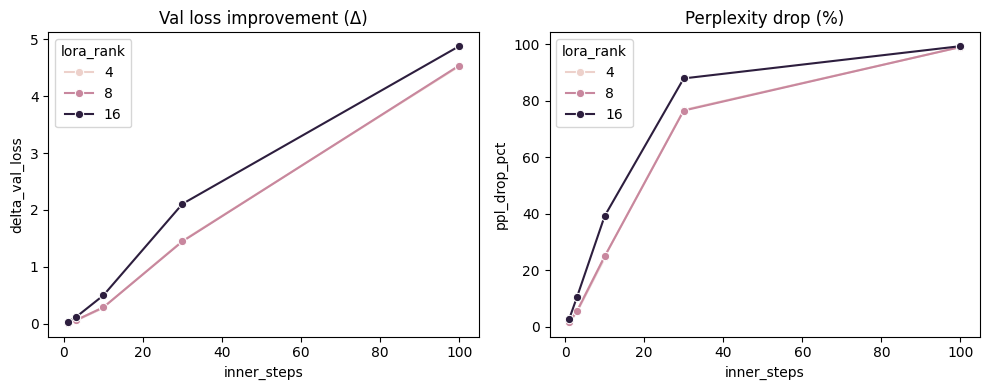

In [24]:
import json, math, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
df = pd.read_json('results/gpt2_seal/adapt.jsonl', lines=True)
df['ppl_before'] = df['val_before'].apply(math.exp)
df['ppl_after'] = df['val_after'].apply(math.exp)
df['ppl_drop_pct'] = (df['ppl_before'] - df['ppl_after']) / df['ppl_before'] * 100
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.lineplot(data=df, x='inner_steps', y='delta_val_loss', hue='lora_rank', marker='o', ax=ax[0])
ax[0].set_title('Val loss improvement (Δ)')
sns.lineplot(data=df, x='inner_steps', y='ppl_drop_pct', hue='lora_rank', marker='o', ax=ax[1])
ax[1].set_title('Perplexity drop (%)')
plt.tight_layout(); plt.show()

In [31]:
!pip -q install "transformers<5,>=4.44.0" "datasets>=2.15,<3" "peft>=0.8,<0.13" "accelerate>=0.27,<1"
"bitsandbytes>=0.44.0"

'bitsandbytes>=0.44.0'

In [32]:
!python -m src.gpt2_qlora.train --model_name gpt2 --train_file data/train.jsonl --val_file data/val.jsonl --data_format jsonl --text_key text --output_dir checkpoints/gpt2_qlora_jsonl --lora_r 8 --block_size 128 --batch_size 2 --epochs 1 --lr 1e-4

2025-10-09 22:58:07.064631: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-09 22:58:07.082447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760050687.103573    9409 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760050687.109952    9409 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760050687.126415    9409 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [33]:
!python -m src.seal.hf_seal --model_name gpt2 --baseline_adapter checkpoints/gpt2_qlora_jsonl --save_dir checkpoints/ gpt2_seal/adapt_jsonl --results results/gpt2_seal/adapt_jsonl.jsonl--inner_steps 1 3 10 30 100 --lora_rank 4 8 16 --train_file data/train.jsonl --val_file data/val.jsonl --data_format json --text_key text --block_size 128

2025-10-09 22:59:14.468455: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-09 22:59:14.486543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760050754.508114    9827 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760050754.514689    9827 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760050754.531412    9827 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [34]:
!python scripts/run_qlora_sweep.py --train_file data/train.jsonl --val_file data/val.jsonl --output_dir checkpoints/sweeps/rank --model_name gpt2 --lora_r 4 8 16 32 --epochs 1 --block_size 128 --batch_size 2 --data_format jsonl --text_key text

Running: python -m src.gpt2_qlora.train --model_name gpt2 --train_file data/train.jsonl --output_dir checkpoints/sweeps/rank/gpt2_r4 --lora_r 4 --epochs 1 --block_size 128 --batch_size 2 --val_file data/val.jsonl --data_format jsonl --text_key text
2025-10-09 23:00:12.920763: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-09 23:00:12.939471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760050812.960839   10118 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760050812.967231   10118 cuda_blas.cc:1407] Unable to regis

In [36]:
# Cell 1 — Colab
!pip -q install "transformers<5,>=4.44.0" "datasets>=2.15,<3" "peft>=0.8,<0.13" "accelerate>=0.27,<1" "bitsandbytes>=0.44.0"

In [5]:
!pip -q install "transformers<5,>=4.44.0" "datasets>=2.15,<3" "peft>=0.8,<0.13" "accelerate>=0.27,<1" "bitsandbytes>=0.44.0"
# After this finishes: Runtime → Restart runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 17.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.


In [6]:
import torch, transformers
print('Torch:', torch.__version__)
print('Transformers:', transformers.__version__)
print('CUDA available:', torch.cuda.is_available())
!nvidia-smi || true

Torch: 2.8.0+cu126
Transformers: 4.56.2
CUDA available: True
Thu Oct  9 23:09:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   35C    P0             55W /  400W |       5MiB /  81920MiB |      0%      Default |
|                                         |                        |           

In [7]:
!git clone https://github.com/Hussain0327/Ai-Research.git /content/Ai-Research
%cd /content/Ai-Research

Cloning into '/content/Ai-Research'...
remote: Enumerating objects: 407, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 407 (delta 54), reused 125 (delta 43), pack-reused 254 (from 1)
Receiving objects: 100% (407/407), 453.97 KiB | 22.70 MiB/s, done.
Resolving deltas: 100% (176/176), done.
/content/Ai-Research


In [8]:
from google.colab import drive
drive.mount('/content/drive')
# Example destination for checkpoints/results
OUTPUT_ROOT = '/content/drive/MyDrive/ai_research'

Mounted at /content/drive


In [9]:
%%bash
python - <<'PY'
import json, random, os
random.seed(42)
os.makedirs('data', exist_ok=True)
lines = [json.loads(l) for l in open('text.JSONL','r')]
random.shuffle(lines)
k = int(0.9*len(lines)) or 1
with open('data/train.jsonl','w') as f:
    for r in lines[:k]: f.write(json.dumps(r)+'\n')
with open('data/val.jsonl','w') as f:
    for r in lines[k:]: f.write(json.dumps(r)+'\n')
print('Wrote', k, 'train and', len(lines)-k, 'val')
PY

Wrote 180 train and 20 val


In [10]:
%cd /content/Ai-Research
!python -m src.gpt2_qlora.train \
  --model_name gpt2 \
  --train_file data/train.jsonl \
  --val_file data/val.jsonl \
  --data_format jsonl \
  --text_key text \
  --output_dir checkpoints/gpt2_qlora_jsonl \
  --lora_r 8 \
  --block_size 128 \
  --batch_size 2 \
  --epochs 1 \
  --lr 1e-4

/content/Ai-Research
2025-10-09 23:10:41.791092: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-09 23:10:41.808905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760051441.831215    2448 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760051441.837789    2448 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760051441.854704    2448 computation_placer.cc:177] computation placer already registered. Please check linka

In [11]:
%cd /content/Ai-Research
!python -m src.gpt2_qlora.eval \
  --model_name gpt2 \
  --adapter_dir checkpoints/gpt2_qlora_jsonl \
  --eval_file data/val.jsonl \
  --data_format jsonl --text_key text \
  --block_size 128 --max_batches 200

/content/Ai-Research
2025-10-09 23:11:27.422492: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-09 23:11:27.442716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760051487.465376    2826 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760051487.472172    2826 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760051487.490618    2826 computation_placer.cc:177] computation placer already registered. Please check linka

In [12]:
%cd /content/Ai-Research
!python -m src.seal.hf_seal \
  --model_name gpt2 \
  --baseline_adapter checkpoints/gpt2_qlora_jsonl \
  --save_dir checkpoints/gpt2_seal/adapt_jsonl \
  --results results/gpt2_seal/adapt_jsonl.jsonl \
  --inner_steps 1 3 10 30 100 \
  --lora_rank 4 8 16 \
  --train_file data/train.jsonl \
  --val_file data/val.jsonl \
  --data_format jsonl --text_key text \
  --block_size 128

/content/Ai-Research
2025-10-09 23:11:42.678242: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-09 23:11:42.695490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760051502.717084    2927 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760051502.723556    2927 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760051502.739737    2927 computation_placer.cc:177] computation placer already registered. Please check linka

In [13]:
%cd /content/Ai-Research
!python scripts/run_qlora_sweep.py \
  --train_file data/train.jsonl \
  --val_file data/val.jsonl \
  --output_dir checkpoints/sweeps/rank \
  --model_name gpt2 \
  --lora_r 4 8 16 32 \
  --epochs 1 \
  --block_size 128 \
  --batch_size 2 \
  --data_format jsonl --text_key text

/content/Ai-Research
Running: python -m src.gpt2_qlora.train --model_name gpt2 --train_file data/train.jsonl --output_dir checkpoints/sweeps/rank/gpt2_r4 --lora_r 4 --epochs 1 --block_size 128 --batch_size 2 --val_file data/val.jsonl --data_format jsonl --text_key text
2025-10-09 23:14:58.203538: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-09 23:14:58.222779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760051698.245034    3879 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760051698.251780    3879 cuda_blas.cc:

In [14]:
%cd /content/Ai-Research
!python scripts/analyze_adaptation.py \
  --logs results/gpt2_seal/adapt_jsonl.jsonl \
  --output_dir results/gpt2_seal/analysis_jsonl

/content/Ai-Research
Wrote plots and summary to results/gpt2_seal/analysis_jsonl


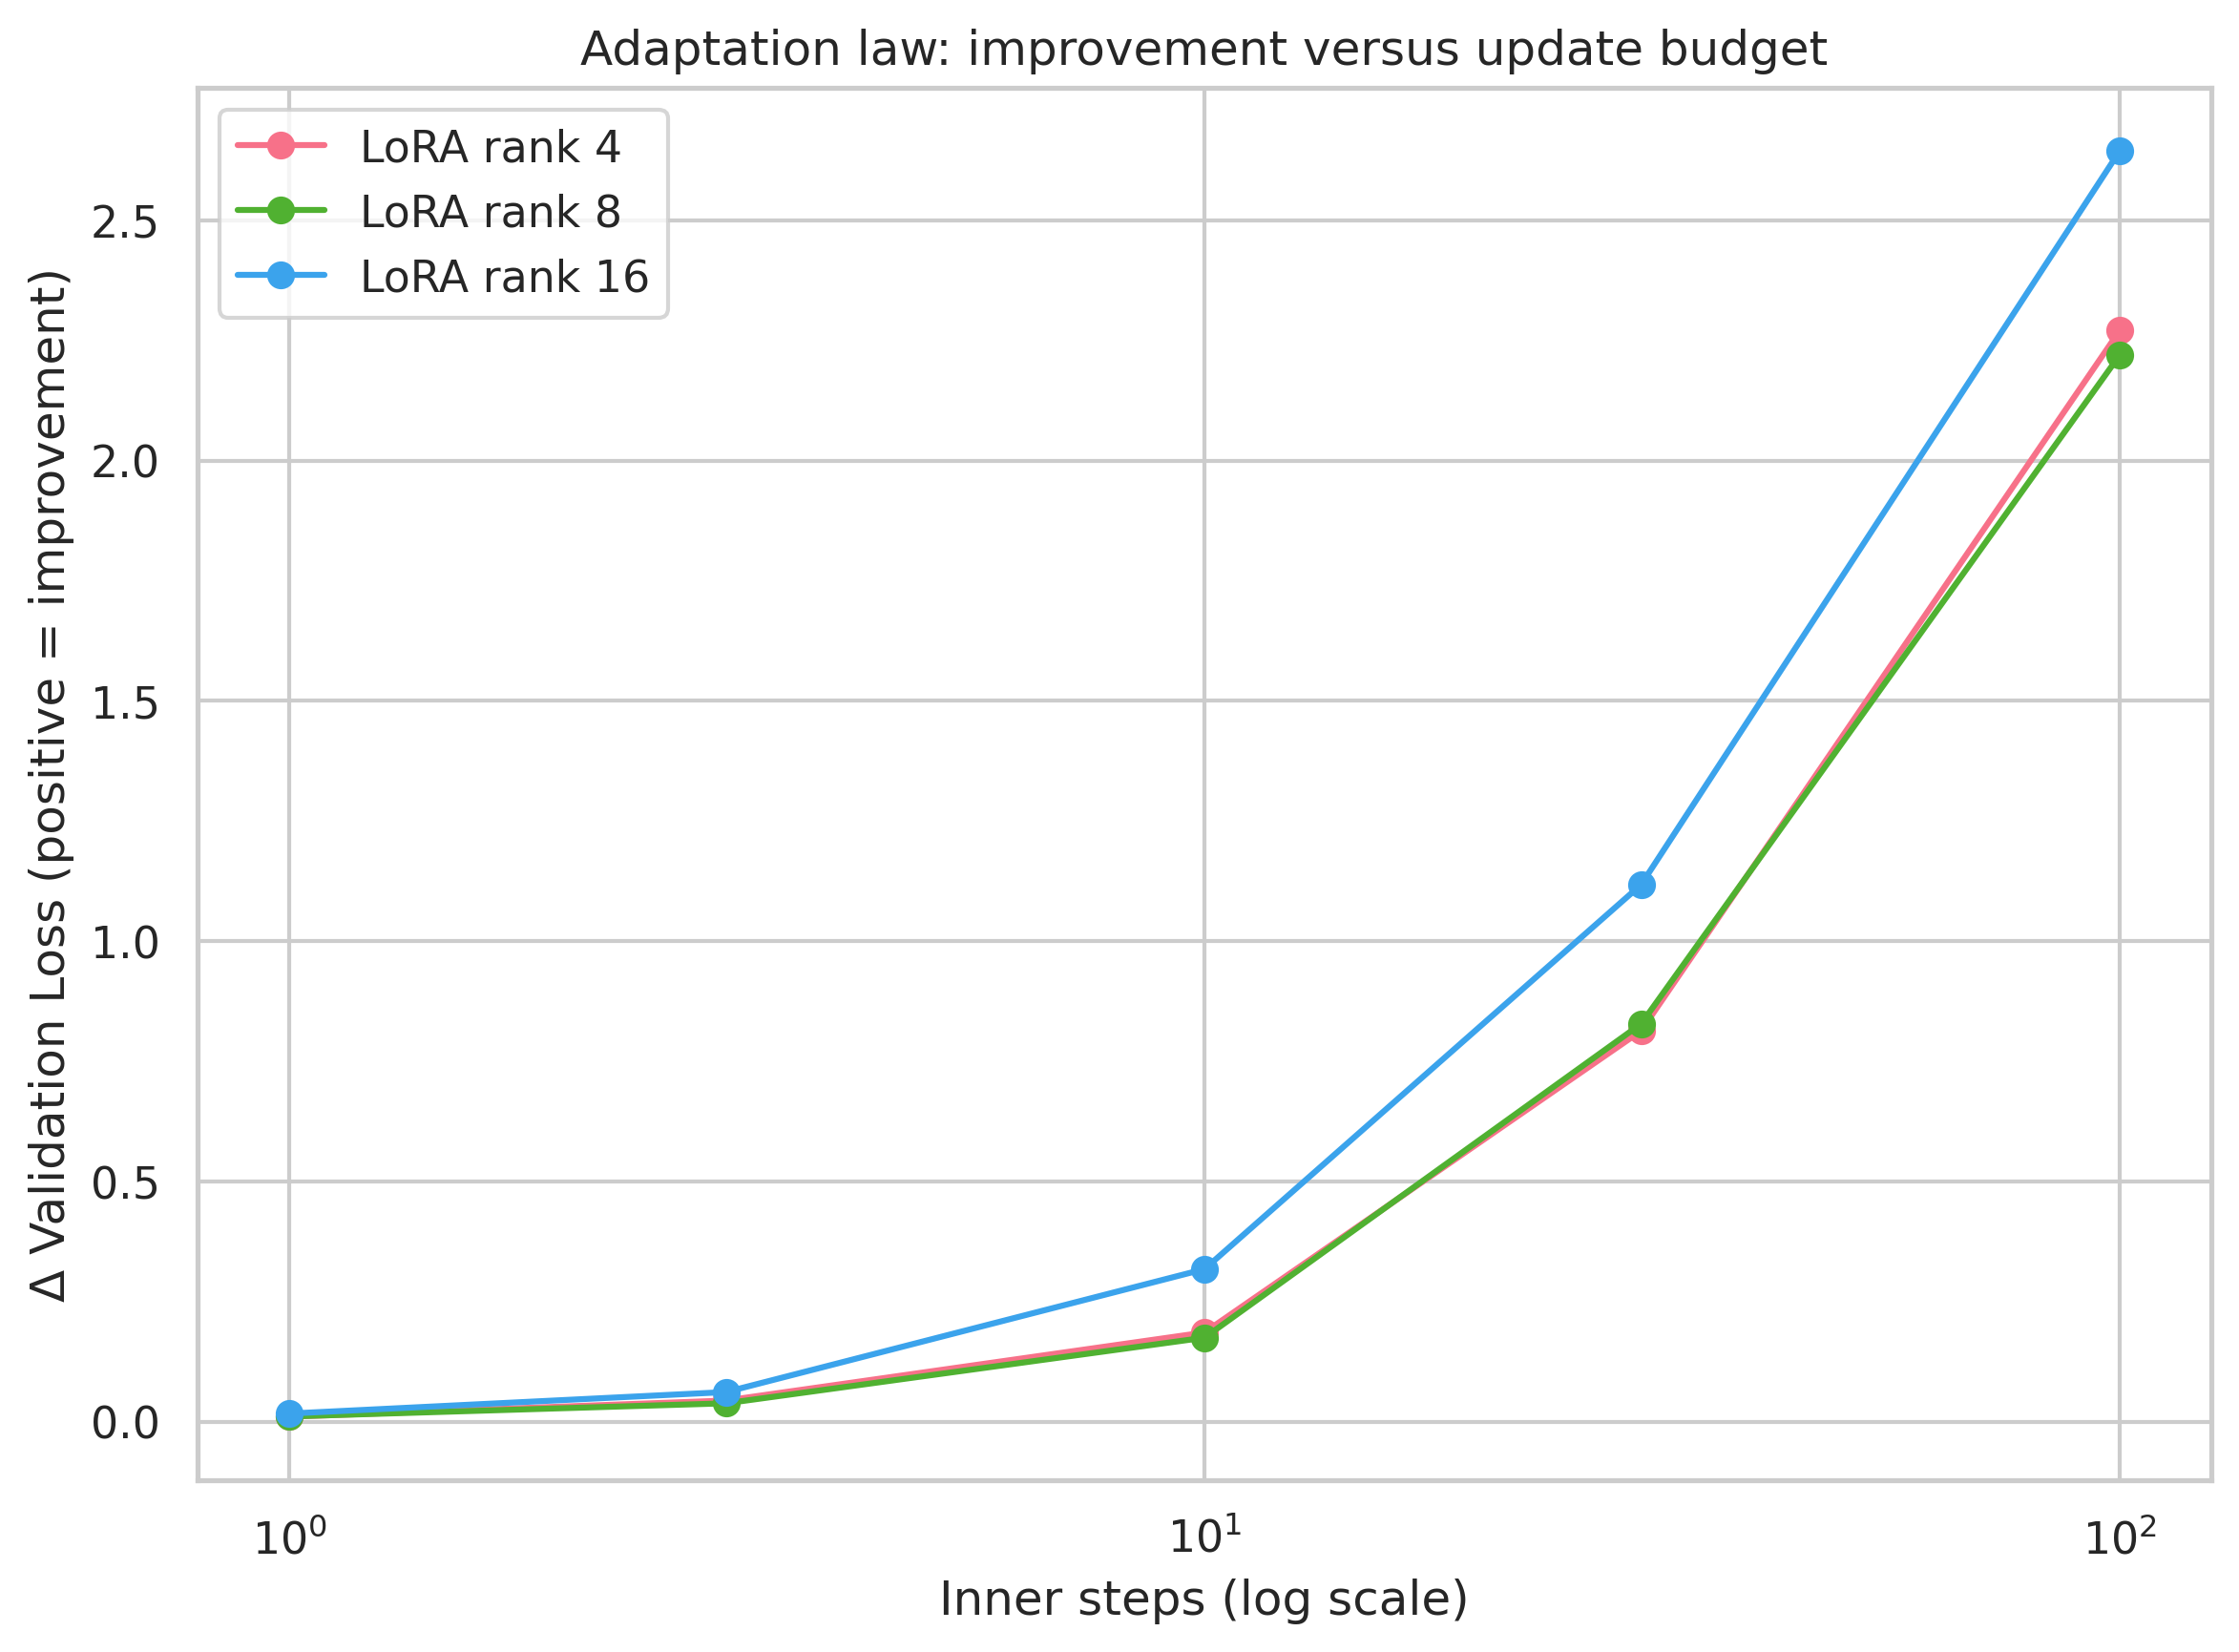

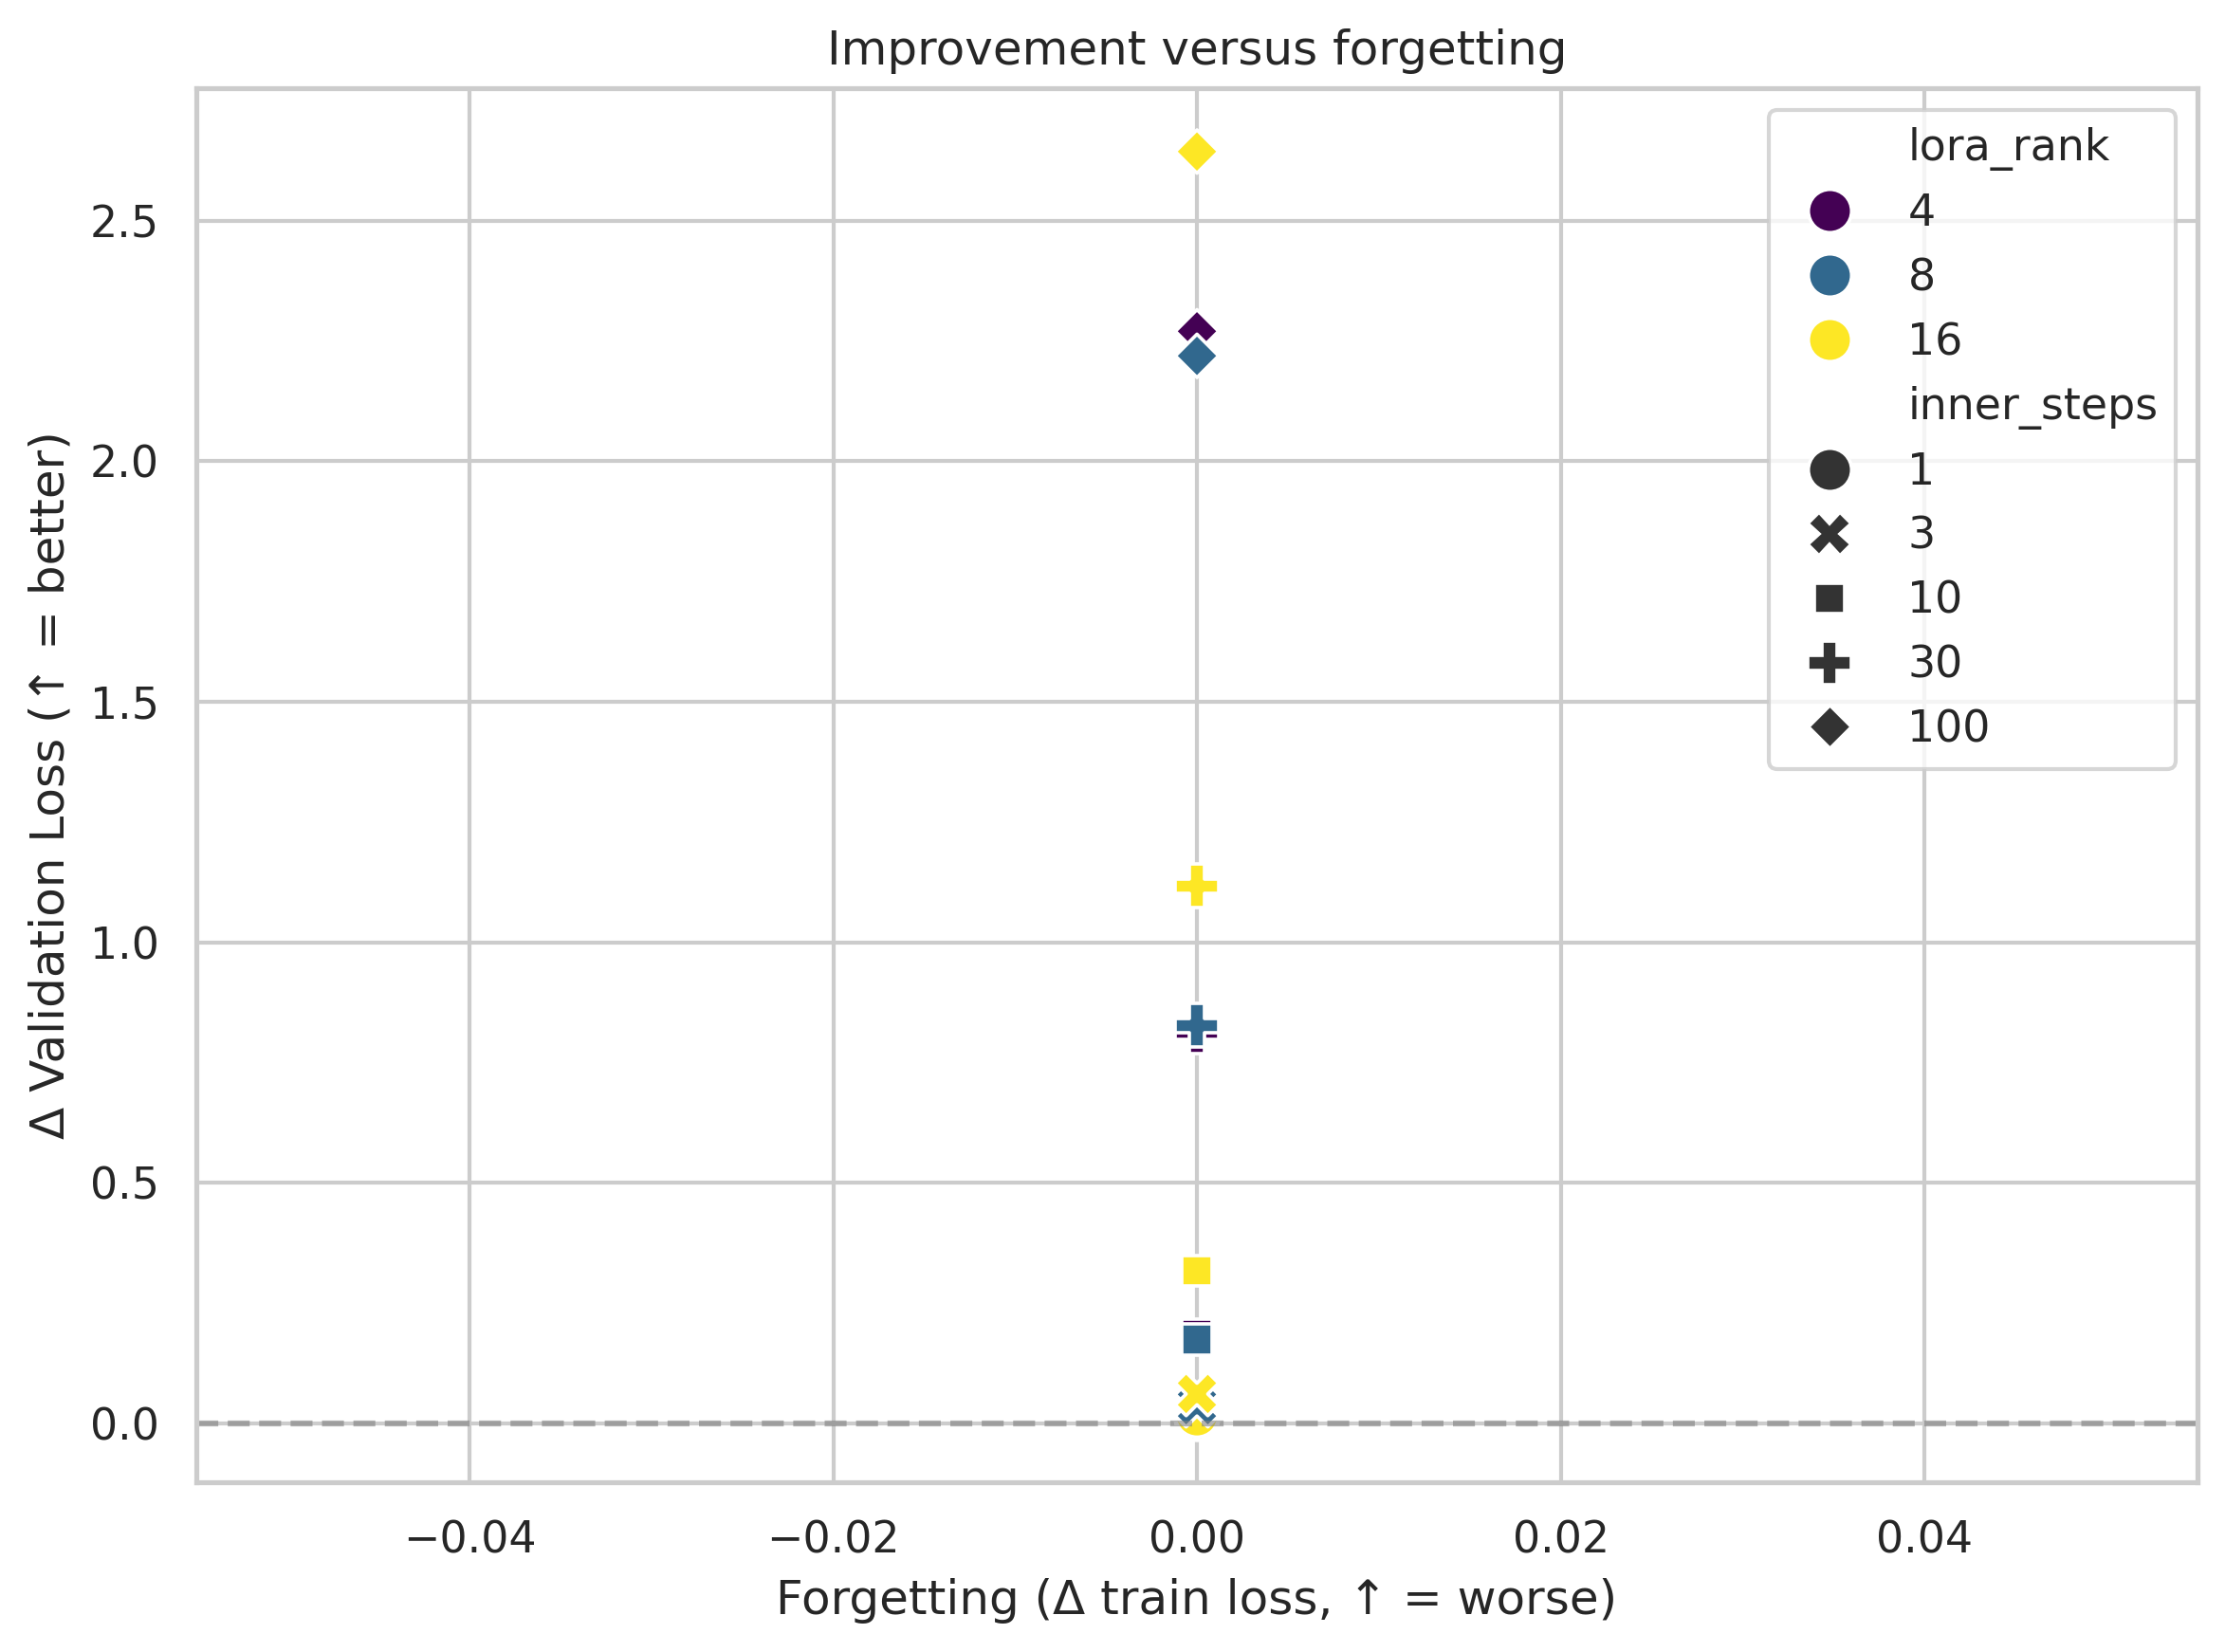

In [15]:
from IPython.display import Image, display
display(Image('results/gpt2_seal/analysis_jsonl/adaptation_laws.png'))
display(Image('results/gpt2_seal/analysis_jsonl/pareto_forgetting.png'))

In [ ]:
Looks solid — the curves show the behavior you want.

  Observations

  - Monotonic gains: more inner steps → higher Δ val loss.
  - Rank ordering: r16 > r8 ≈ r4 once steps ≥10; near-tied at tiny budgets.
  - Roughly sublinear scaling with steps; no clear saturation by 100 steps.
  - No anomalies between the two plots; they’re effectively identical.

  Suggestions

  - Extend budgets: add 200, 300, 500 steps to find the knee.
  - Add r=32 to see if rank keeps paying off at higher budgets.
  - Sweep LR (3e-4, 5e-4, 1e-3); higher rank often prefers slightly lower LR.
  - Report PPL drop: given baseline loss L0, PPL_after ≈ exp(L0−Δ). Include this on plots.
  - Add error bars: run 3 seeds and plot mean±std; avoids overfitting to a lucky seed.
  - Plot improvement vs tokens processed (not steps) for compute‑normalized comparisons.

  Fast Follow (in Colab)

  - Keep SEAL logging to Drive so you don’t lose runs, then:
      - python -m src.seal.hf_seal ... --inner_steps 1 3 10 30 100 300 --lora_rank 4 8 16 32
      - python scripts/analyze_adaptation.py --logs results/gpt2_seal/adapt_jsonl.jsonl --output_dir results/gpt2_seal/
        analysis_jsonl

  If you want, I can add seed repeats, tokens-processed plots, and a rank=32 run to the notebook and commit the updated
  analysis.